In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!ls gdrive/My\ Drive/SoHPC/Dnn_project/models/*
!pip install tensorflow-probability==0.10.1

'gdrive/My Drive/SoHPC/Dnn_project/models/trained50.h5'
'gdrive/My Drive/SoHPC/Dnn_project/models/untrained50.h5'
'gdrive/My Drive/SoHPC/Dnn_project/models/untrained.h5'

'gdrive/My Drive/SoHPC/Dnn_project/models/logs':
20200728-090845  20200728-094426  20200728-102417  20200728-194743
20200728-093328  20200728-095150  20200728-114122  20200728-195237
20200728-094146  20200728-095813  20200728-114715  20200728-195507


In [ ]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import os
from keras import backend as K
#from classification_models.tfkeras.models import Classifiers
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

# Change parameters here...
data_dir = 'gdrive/My Drive/SoHPC/Dnn_project/data/' # Change
log_dir = 'gdrive/My Drive/SoHPC/Dnn_project/models/logs/'
sizex = 500
sizey = 500
sizez = 3
num_datasets = 10
batch_size = 15
nb_epochs = 2
validation_ratio = 0.3
num_components = 2 #2 angles

Using TensorFlow backend.


In [ ]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')
numpy_datasets = numpy_datasets[1:]

In [ ]:
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        print(dataset, data['x_dust'].shape)
        if 'x_dust' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

gdrive/My Drive/SoHPC/Dnn_project/data/dataset_65.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_2_10.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_10.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_2_80.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_70.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_85.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_2_40.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_25.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_2_20.p.npz (20, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_60.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_75.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_35.p.npz (25, 500, 500, 3)
gdrive/My Drive/SoHPC/Dnn_project/data/dataset_95.p.npz (20, 500, 500, 3)


In [ ]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images)
data_dict['x_dust'].shape

(315, 500, 500, 3)

In [ ]:
# Normalice the angular momentum
from sklearn.preprocessing import normalize

# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

'''data_dict['y_norm'] = normalize(data_dict['y'], axis=1)
data_dict['y_angle'] = cart_to_esf(data_dict['y_norm'])
data_dict['y_ang'] = break_degeneracy(data_dict['y_angle'])
data_dict['y_ang_norm'] = map_to_1(data_dict['y_ang'])
data_dict['y_xyz_nd'] = esf_to_cart(data_dict['y_ang'])
data_dict['y_xyz']   = esf_to_cart(data_dict['y_angle'])'''

# computing the normaliced angle and the come back to cartesian to check the conversion
data_dict['y_angle'] = break_degeneracy(cart_to_esf(normalize(data_dict['y'], axis=1)))
data_dict['y_xyz_nd']= esf_to_cart(data_dict['y_angle'])
data_dict['y_angle'] = map_to_1(data_dict['y_angle'])

In [ ]:
# check the shape of our dictionary
print(data_dict['y_angle'].shape)

(315, 2)


In [ ]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# functions to visualice the data 
def viz(ds):
    elem = ds.take(3)
    for e in elem:
        img = e['x_nodust'][:, :,:]
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
        ax.arrow(250,250,100*e['y_xyz_nd'][0],100*e['y_xyz_nd'][1], head_width=7, head_length=10, fc='g', ec='g')
        #display(Markdown("#### **Label:** {}".format(e['y_norm'])))
        display(Markdown("#### **angle:** {}".format(e['y_angle'])))
        display(Markdown("#### **inverse:** {}".format(e['y_xyz_nd'])))
        print(e['ids'])
        plt.show()
        break

def viz_batch(ds, idx):
    elem = ds.take(idx) # get first batch
    for e in elem:
        img = e['x_nodust'][idx, :, :,:]
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255, origin='lower')
        ax.arrow(250,250,100*e['y_xyz_nd'][0,0],100*e['y_xyz_nd'][0,1], head_width=7, head_length=10, fc='g', ec='g')
        #display(Markdown("#### **Label:** {}".format(e['y_norm'][idx])))
        display(Markdown("#### **angle:** {}".format(e['y_angle'][idx])))
        display(Markdown("#### **inverse:** {}".format(e['y_xyz_nd'][idx])))
        print(e['ids'][idx])
        plt.show()
        break
        
# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_angle: (2,), y_xyz_nd: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_angle: tf.float64, y_xyz_nd: tf.float64}>


#### **angle:** [0.56040278 0.84607795]

#### **inverse:** [-0.86945268  0.45658841 -0.18862412]

tf.Tensor(b'g4.86e10_x302_y97_z327', shape=(), dtype=string)


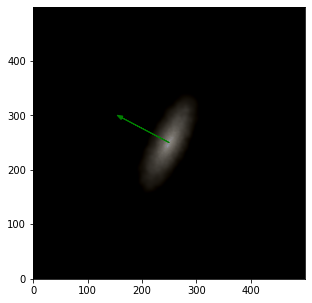

#### **angle:** [0.63168172 0.26672555]

#### **inverse:** [ 0.61255926  0.68056913 -0.40199107]

tf.Tensor(b'g7.05e09_x228_y233_z199', shape=(), dtype=string)


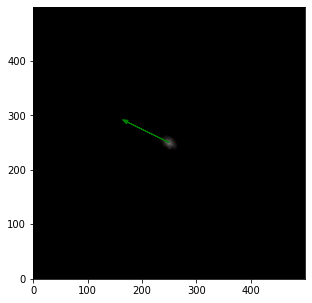

#### **angle:** [0.26451999 0.54080622]

#### **inverse:** [-0.09442877  0.73255434  0.6741271 ]

tf.Tensor(b'g5.02e11_x353_y78_z41', shape=(), dtype=string)


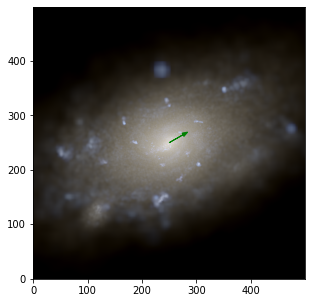

#### **angle:** [0.9284296  0.48419617]

#### **inverse:** [ 0.011065    0.22268056 -0.97482867]

tf.Tensor(b'g7.05e09_x321_y317_z126', shape=(), dtype=string)


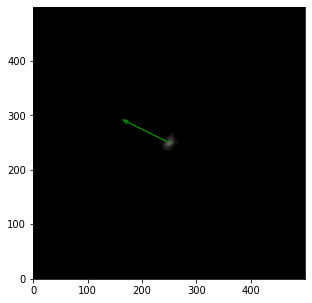

#### **angle:** [0.58552068 0.73802287]

#### **inverse:** [-0.6556105   0.70690233 -0.26545048]

tf.Tensor(b'g5.02e11_x185_y333_z230', shape=(), dtype=string)


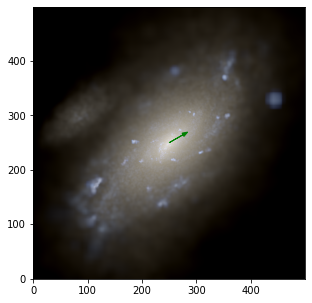

In [ ]:
# visualice the data
viz(dataset)
real_dataset = dataset.batch(batch_size).shuffle(10, seed=321)
for i in range(1,5):
    viz_batch(real_dataset, i) # select any index within the batch, e.g. 2

In [ ]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
ds_size = len(data_dict['y_angle'])

input_ds = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_angle'].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = 123, reshuffle_each_iteration = False)
)

val_size = math.floor(ds_size * validation_ratio)
validation_ds = ( input_ds.take(val_size).batch(batch_size) )
train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=20, reshuffle_each_iteration=True).batch(batch_size) )

print(train_ds)
print(validation_ds)

<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir 'gdrive/My Drive/SoHPC/Dnn_project/models/logs'

Reusing TensorBoard on port 6006 (pid 627), started 0:16:06 ago. (Use '!kill 627' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
#ResNet34, preprocess_input = Classifiers.get('resnet34')

base_model = tf.keras.applications.ResNet50(input_shape=(sizey,sizex,3), 
                                          weights='imagenet', include_top=False)

#Define the negative log likelihood
def nll1(y_true, y_pred):
    """ Negative log likelihood. """
    # keras.losses.binary_crossentropy give the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

negloglik = lambda y, p_y: -p_y.log_prob(y)

# Build model
#base_model = ResNet34(input_shape=(sizey,sizex,3), weights='imagenet', include_top=False)

# redefine the output to be from tensorflow probability a PDF
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x_2 = tf.keras.layers.Dense(tfpl.IndependentNormal.params_size(2), activation=None)(x)
#tfpl.IndependentNormal(input_shape, tfd.Normal.mean),
output = tfpl.IndependentNormal(2, tfd.Normal.sample)(x_2)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
snapshot_weights = 'best_weights.hdf5'
if os.path.isfile(snapshot_weights):
    model.load_weights(snapshot_weights)
    
model.compile(optimizer='SGD', loss='MeanSquaredError', metrics=['accuracy'])
model.summary()
# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)

callbacks = [
    tensorboard_callback,
    checkpointer
]

model.save('gdrive/My Drive/SoHPC/Dnn_project/models/untrained50.h5')

model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

model.save('gdrive/My Drive/SoHPC/Dnn_project/models/trained50.h5') # Not really needed as we have the weights already

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 506, 506, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 250, 250, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 250, 250, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
def map_to_180(ang_norm):
  angle = ang_norm*180
  return angle

predictions = model.predict(validation_ds)
predictions = map_to_180(predictions)
predictions = esf_to_cart(predictions)
print(predictions)

[[-0.04154552 -0.044577    0.99814171]
 [-0.58979005  0.72209692  0.36155736]
 [ 0.11712107 -0.693183    0.71118206]
 [ 0.00490692  0.17468658 -0.98461187]
 [ 0.53416824 -0.31767964 -0.78341806]
 [ 0.49245813  0.21649265  0.84298038]
 [ 0.31157938  0.94969589  0.03155943]
 [ 0.58661449  0.79916924  0.13119446]
 [ 0.25042629 -0.92657232  0.28062513]
 [-0.01990062  0.35549685  0.93446559]
 [ 0.05980782  0.04921532  0.99699593]
 [-0.18927599  0.68194568  0.70648754]
 [-0.1535877   0.04068981  0.98729688]
 [ 0.36388385  0.92894739 -0.06815646]
 [-0.16443828 -0.44599077  0.87980241]
 [ 0.57590377  0.17364721  0.79886264]
 [ 0.10200475  0.45094529  0.88670367]
 [ 0.70103991  0.70819467 -0.08368568]
 [ 0.35884398  0.34519064  0.86722225]
 [ 0.62237412 -0.18135813  0.76141953]
 [ 0.42261532  0.80669206  0.41309109]
 [-0.3955875  -0.16835733 -0.90286565]
 [-0.32433954  0.89032131  0.31958047]
 [-0.28468779 -0.09723258  0.9536764 ]
 [-0.0282782   0.08044753  0.99635762]
 [ 0.67356962  0.42755094